In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve, curve_fit
from scipy.linalg import expm
from scipy.linalg import eig
import scipy.linalg
import matplotlib.pyplot as plt
import control as ct
import cvxpy as cp

import Modified_FourTank_functions as fun   # Import functions
from Modified_FourTank_parameters import p, a1, a2, a3, a4, A1, A2, A3, A4, g, gamma1, gamma2, rho  # Import parameters

Modified 4tank system

# Problem 2
Deterministic and Stochastic Nonlinear Modeling

## 2.1 Deterministic Nonlinear Model

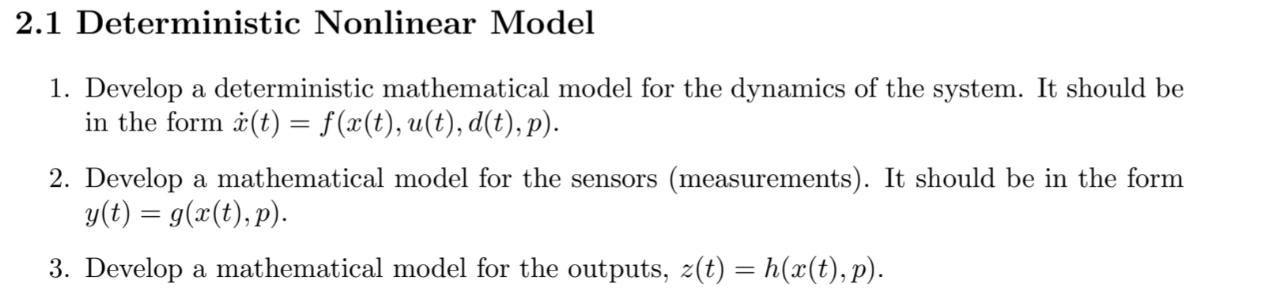

See "Modified_FourTanksystem" function

See "FourTankSystemSensor_Deterministic" function

See "FourTankSystemOutput" function

- What is the difference on sensor and output? and should we use level or mass?


## 2.2 Stochastic Nonlinear Model

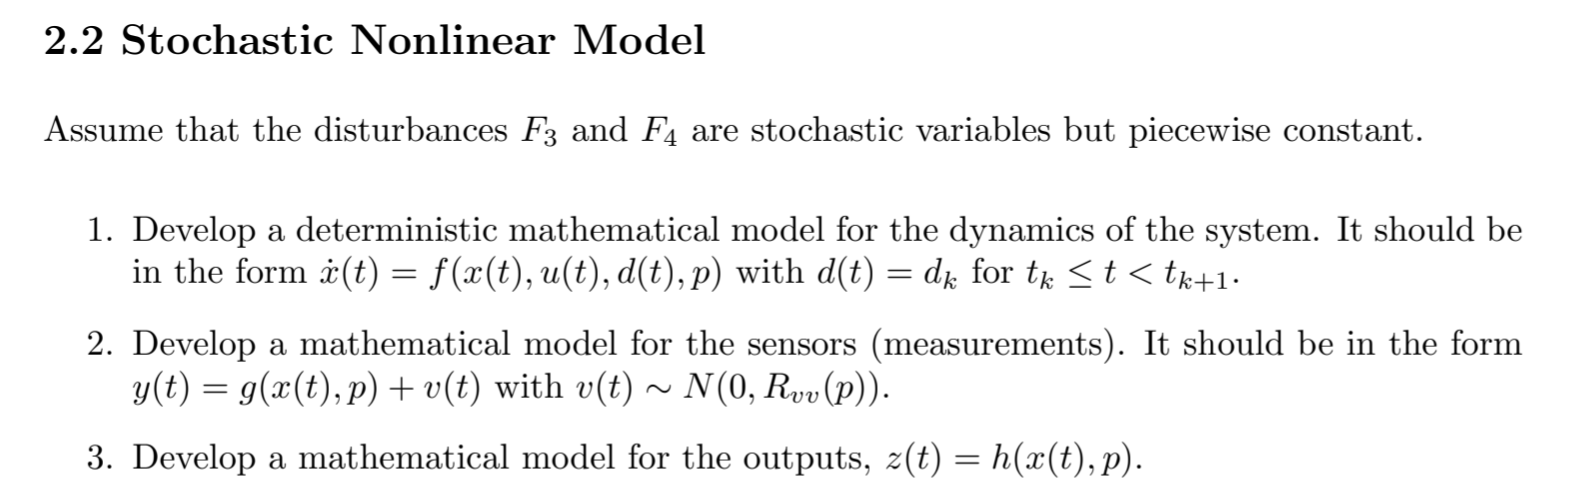

1. See "run_step" function
2. See "FourTankSystemSensor" function
3. See "FourTankSystemOutput" function

## 2.3 Stochastic Nonlinear Model (SDE)

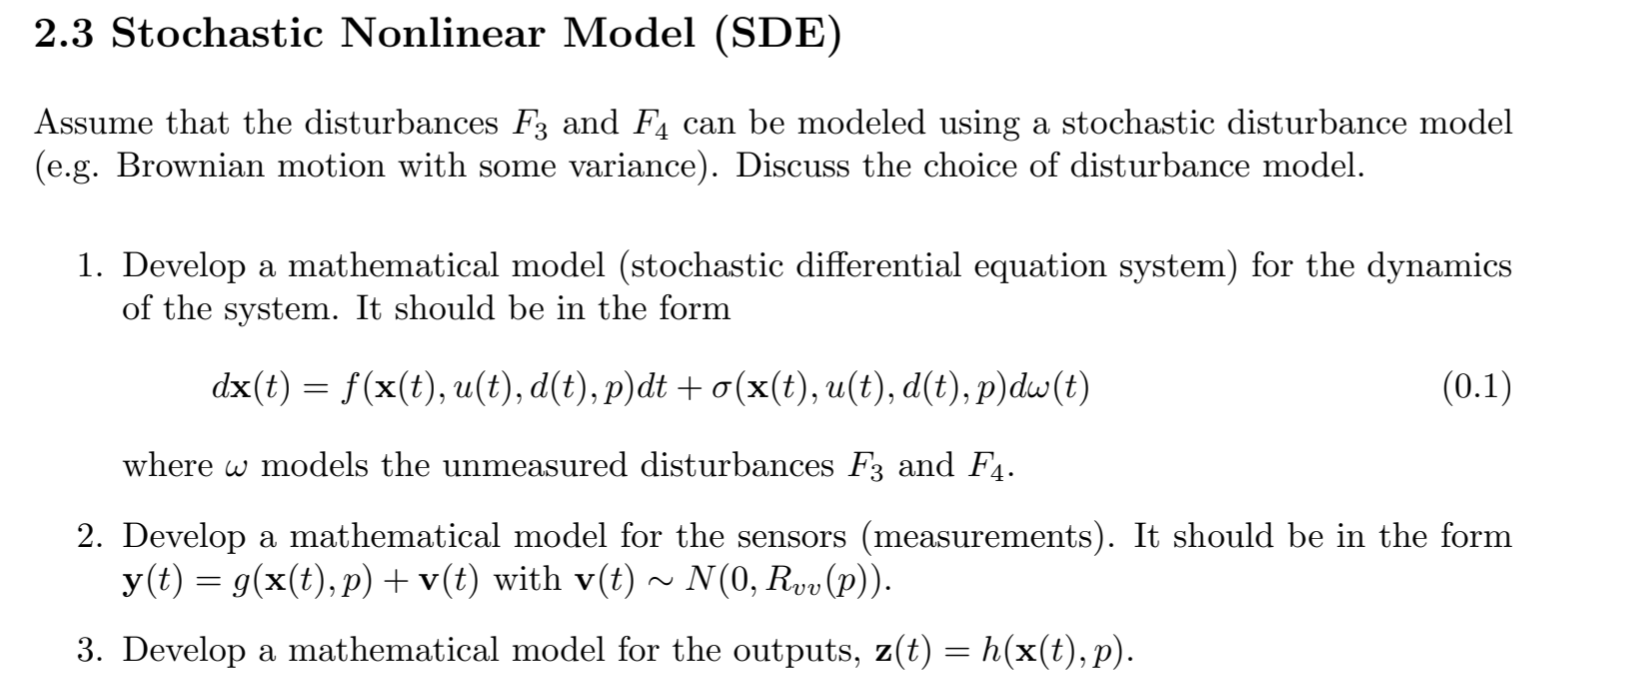

$$
dm_1 = \rho(q_{1in} + q_3 - q_1)dt
$$
$$
dm_2 = \rho(q_{2in} + q_4 - q_2)dt
$$
$$
dm_3 = \rho(q_{3in} - q_3 + \bar{F_3})dt + \sigma_3 d\omega
$$
$$
dm_4 = \rho(q_{4in} - q_4 + \bar{F_4})dt + \sigma_4 d\omega
$$

## 2.4 Simulation

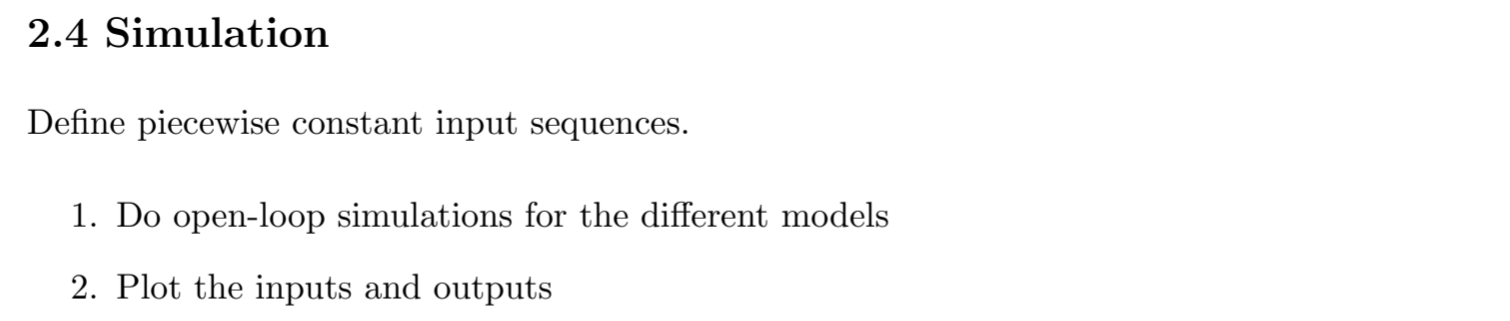

### For model 2.2

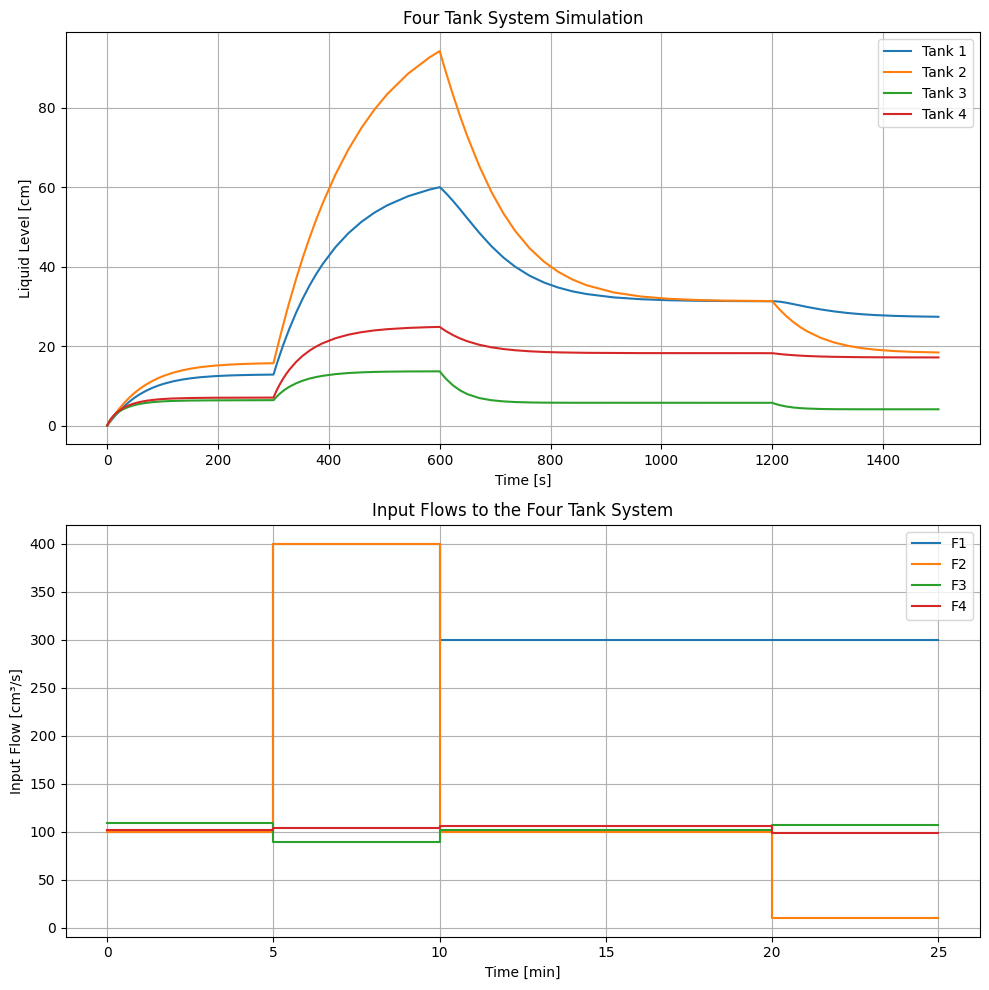

In [3]:
# Initial liquid levels [cm]
h10, h20, h30, h40 = 0.0, 0.0, 0.0, 0.0
# Convert levels to mass [g] => m = rho * A * h
m10 = rho * A1 * h10
m20 = rho * A2 * h20
m30 = rho * A3 * h30
m40 = rho * A4 * h40

x0 = np.array([m10, m20, m30, m40])  # Initial states
times = np.array([0,5,10,20,25])*60 # start and end of each interval
N = len(times)  # number of intervals
nx = len(x0)
F1 = np.array([100,400,300,300])
F2 = np.array([100,400,100,10])
F3 = np.array([100,100,100,100])
F4 = np.array([100,100,100,100])
u = np.array([F1,F2])
d = np.array([F3,F4])

x, y, z, T_all, X_all, H_all = fun.sim22(times, x0, u, d, p, noise_level=5)


### For model 2.3 (still need plot of disturbance with noise)

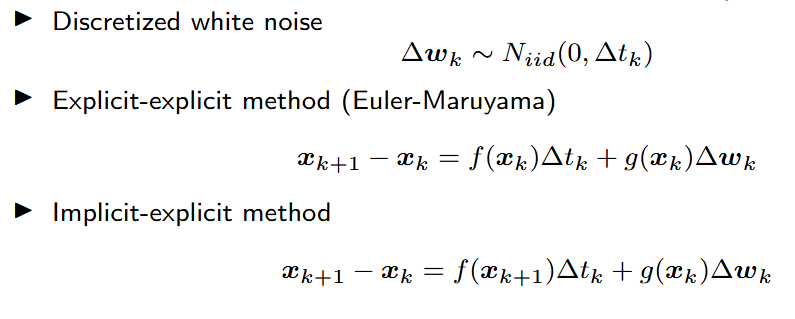

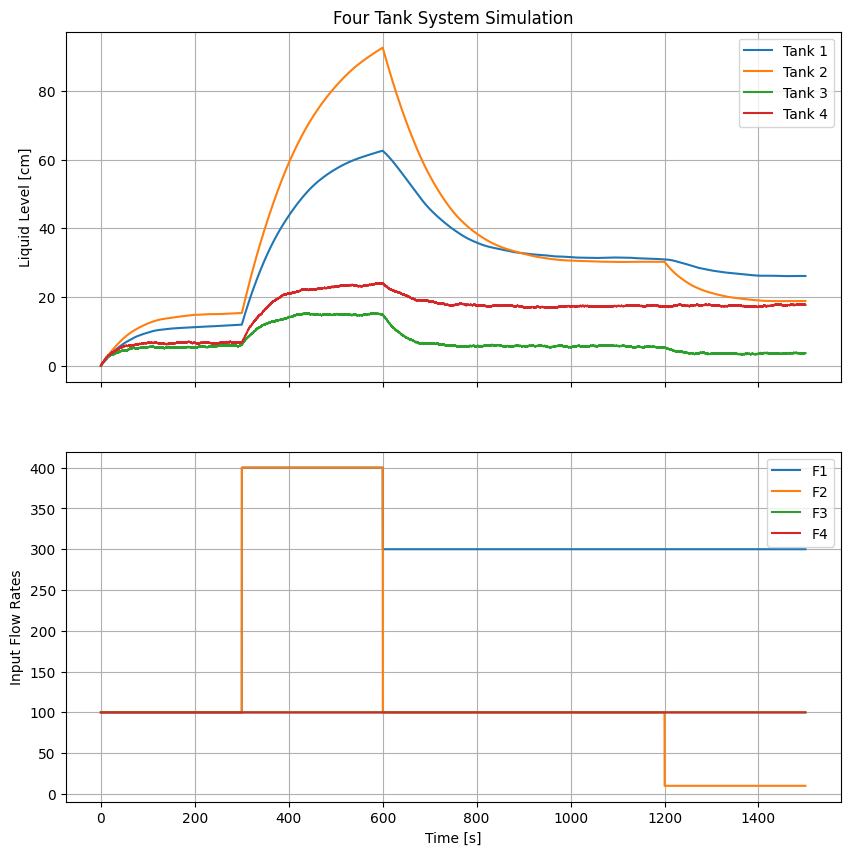

In [4]:
# --- Time and Noise Setup ---
times = np.array([0, 5, 10, 20, 25]) * 60  # in seconds
dt = 0.01

# --- Initial Conditions ---
h10, h20, h30, h40 = 0.0, 0.0, 0.0, 0.0
m10 = rho * A1 * h10
m20 = rho * A2 * h20
m30 = rho * A3 * h30
m40 = rho * A4 * h40
x0 = np.array([m10, m20, m30, m40])

# --- Input Profiles ---
F1 = np.array([100,400,300,300])
F2 = np.array([100,400,100,10])
F3 = np.array([100, 100, 100, 100])
F4 = np.array([100, 100, 100, 100])
u = np.array([F1, F2])
d = np.array([F3, F4])

x = fun.sim23(times, dt, x0, u, d, p, noise_level=20)

# Problem 3

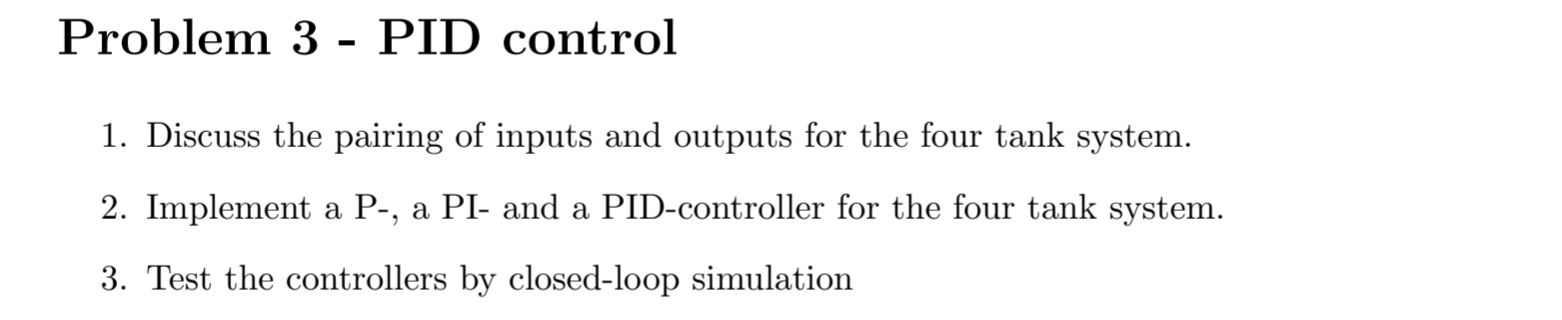

For controllers, steady state input need be known:
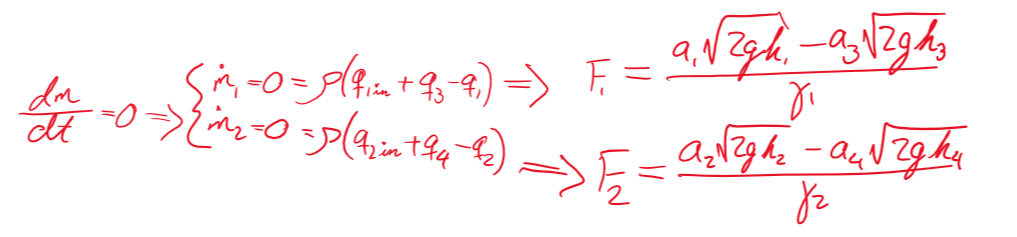

## For model 2.2
Kc is restricted by dt. Solver cannot handle if dt and Kc is too large.

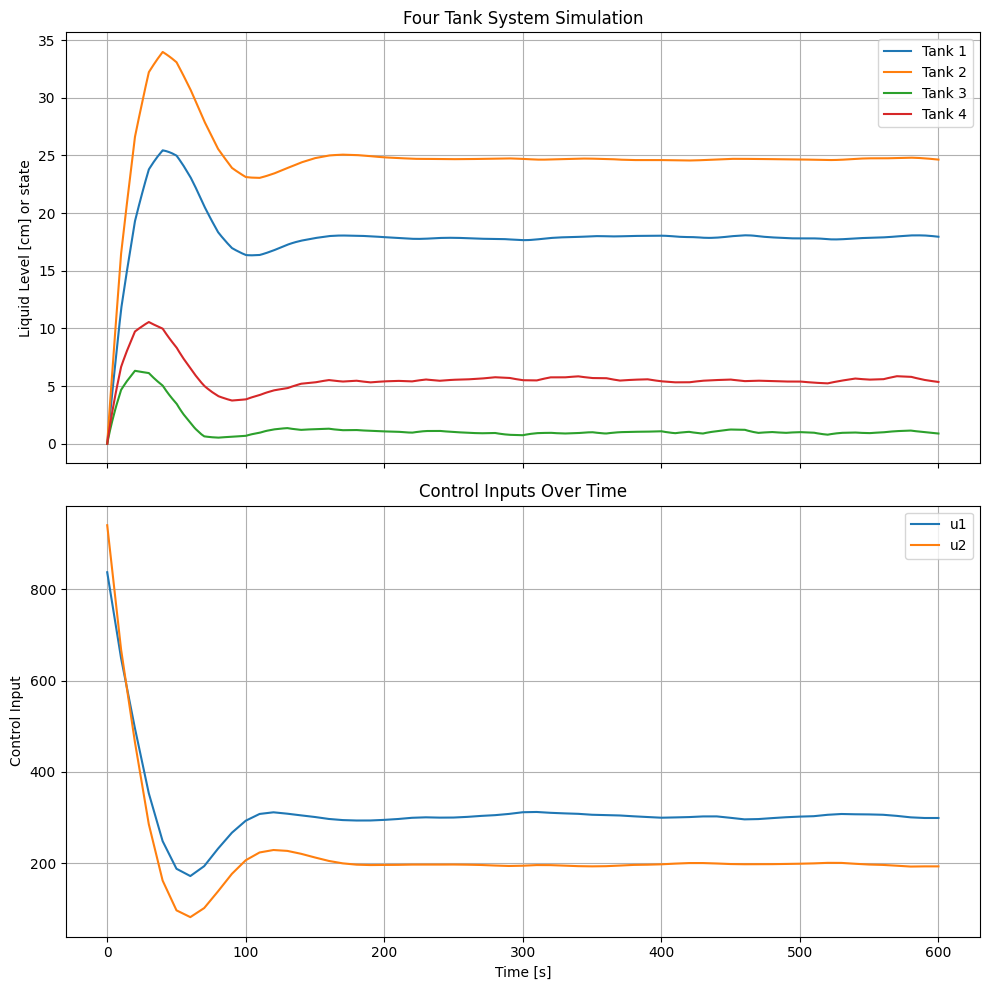

In [5]:
dt = 10   # update every 10sek
t_stop = 10*60
t = np.arange(0,t_stop+dt,dt)
N = len(t)
#F1, F2 = 300, 300
u0 = np.array([0,0])
d = np.zeros([2,N-1])

r = np.array([17.90248217, 24.66734099,  1.06132002,  5.37293261]) # set point (steady state when input is [300,200,0,0])
#u[:,0] = F1,F2

us = fun.compute_steady_state_pump_flow(r,p)

T_all, X_all, H_all, u, y, z = fun.closed_loop_sim22(t, x0, u0, d, p, us, r, controller=fun.PIDcontroller, noise_level=5, Kc=10,Ki=1,Kd=100)

## For model 2.3

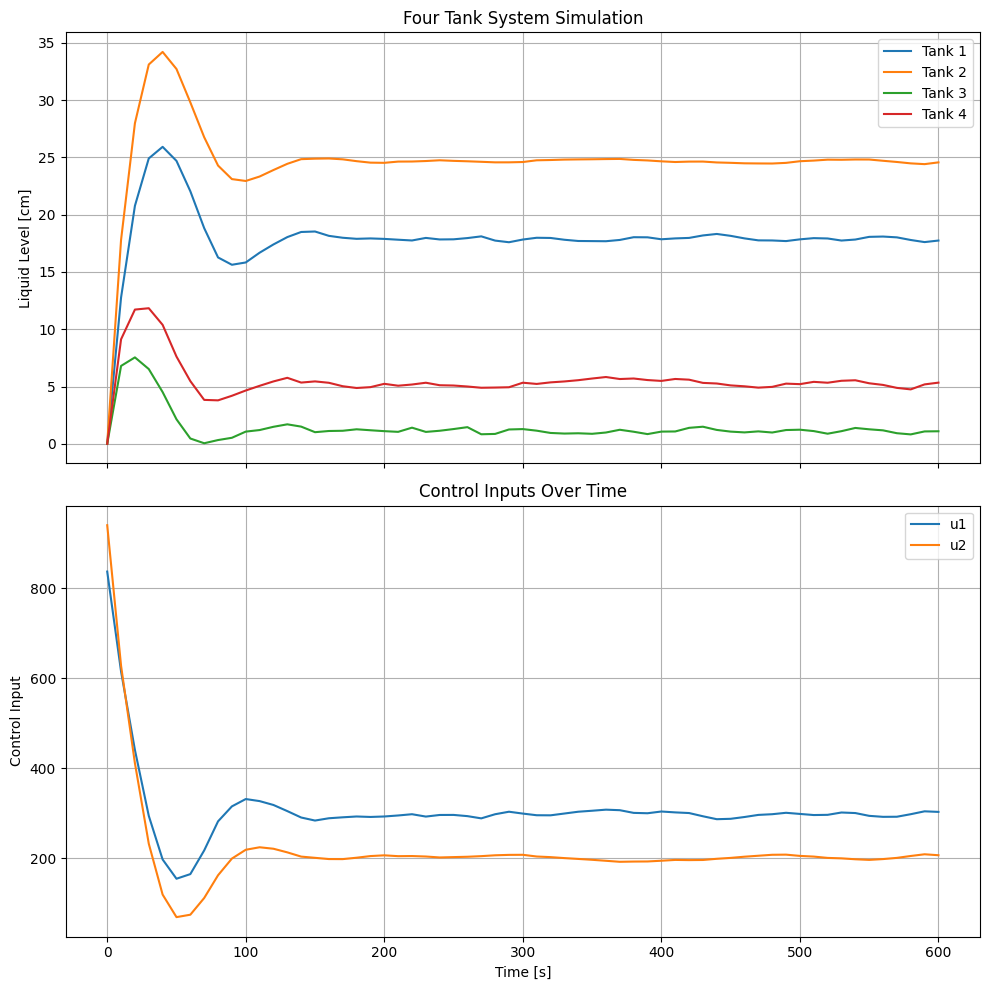

In [6]:
dt = 10   # update every 10sek
t_stop = 10*60
t = np.arange(0,t_stop+dt,dt)
N = len(t)
#F1, F2 = 300, 300
u0 = np.array([0,0])
d = np.zeros([2,N-1])

r = np.array([17.90248217, 24.66734099,  1.06132002,  5.37293261]) # set point (steady state when input is [300,200,0,0])
#u[:,0] = F1,F2

us = fun.compute_steady_state_pump_flow(r,p)

x, y, z, u = fun.closed_loop_sim23(t, x0, u0, d, p, us, r, controller=fun.PIDcontroller, noise_level=20, Kc=10,Ki=1,Kd=100)

# Problem 4
Nonlinear Simulation - Step Responses

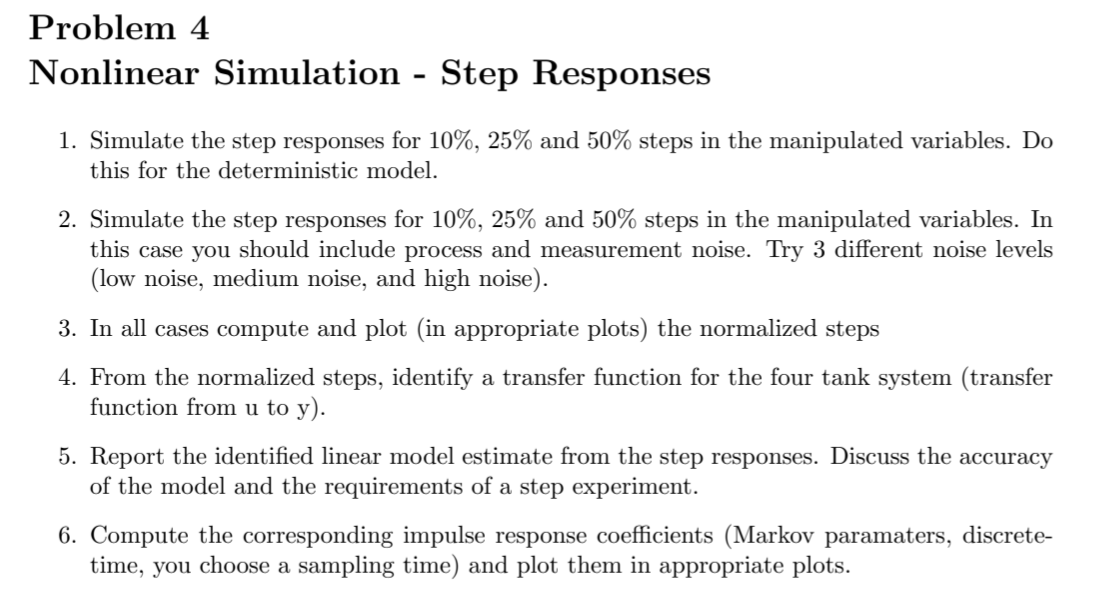

## For model 2.2 deterministic

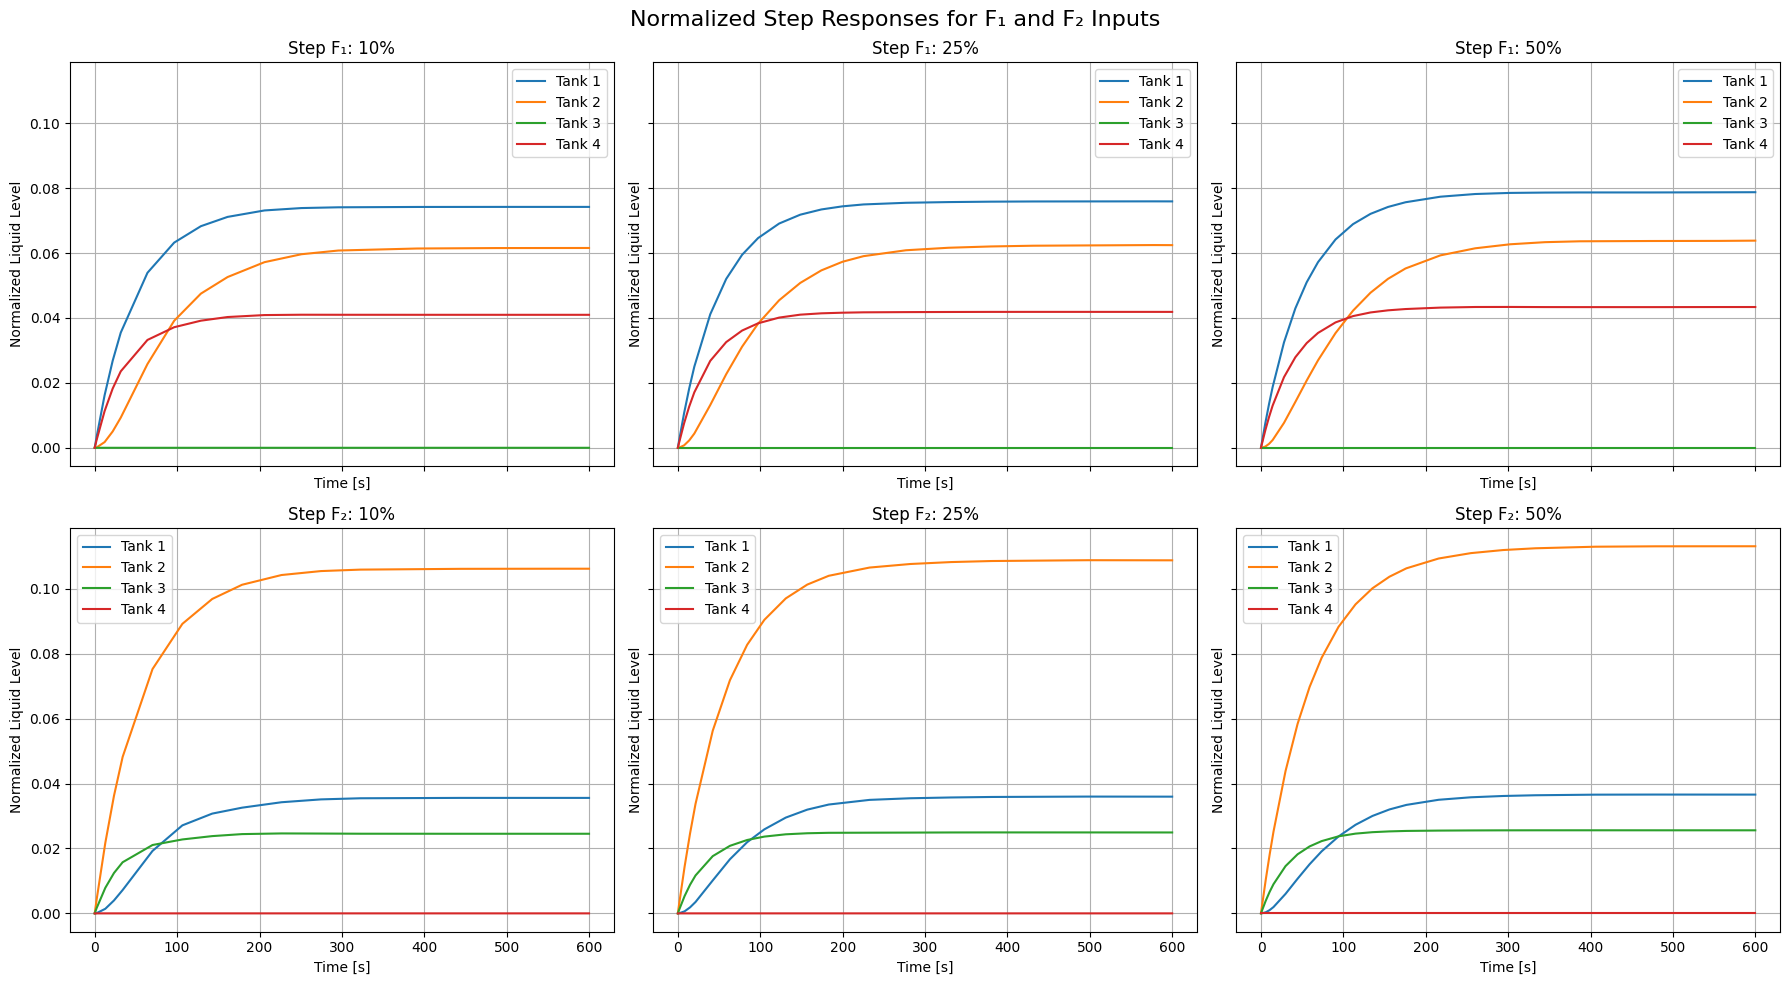

In [7]:
noise_level=0   # change for stochastic models
# Initial liquid levels [cm]
h10, h20, h30, h40 = 0.0, 0.0, 0.0, 0.0 # heights
# Convert levels to mass [g] => m = rho * A * h
m10 = rho * A1 * h10
m20 = rho * A2 * h20
m30 = rho * A3 * h30
m40 = rho * A4 * h40

x0 = np.array([m10, m20, m30, m40])  # Initial states for first simulation
step_pers_list = [0.1, 0.25, 0.5]
results_F1 = []
results_F2 = []

fig, axs = plt.subplots(2, len(step_pers_list), figsize=(18, 10), sharex=True, sharey=True)

for idx, step_pers in enumerate(step_pers_list):
    # --- Common setup ---
    F1_old = np.array([100])
    F2_old = np.array([100])
    F3_old = np.array([100])
    F4_old = np.array([100])
    A = p[4:8]
    rho = p[11]
    times = np.array([0,10])*60
    tf = times[-1]
    t = np.arange(0, tf + dt, dt)

    # --- Steady-state simulation ---
    u = np.array([F1_old, F2_old])
    d = np.array([F3_old, F4_old])
    x, y, z, T_all, X_all, H_all = fun.sim22(times, x0, u, d, p, noise_level=noise_level, plot=False)
    x0_ss = X_all[-1,:].flatten()
    h0_ss = H_all[-1,:].flatten()

    # ============================
    # Simulation: Step in F1 only
    # ============================
    F1 = F1_old * (1 + step_pers)
    F2 = F2_old
    u = np.array([F1, F2])
    x, y, z, T_all, X_all, H_all = fun.sim22(times, x0_ss, u, d, p, noise_level=noise_level, plot=False)
    results_F1.append(x)
    h_end = H_all[-1,:].flatten()
    step_size_F1 = float(F1[0] - F1_old[0])

    # --- Plot F1 step response ---
    for i in range(4):
        axs[0, idx].plot(T_all.flatten(), (H_all[:, i] - h0_ss[i]) / step_size_F1, label=f'Tank {i+1}')
    axs[0, idx].set_title(f'Step F₁: {int(step_pers*100)}%')
    axs[0, idx].set_xlabel('Time [s]')
    axs[0, idx].grid(True)

    # ============================
    # Simulation: Step in F2 only
    # ============================
    F1 = F1_old
    F2 = F2_old * (1 + step_pers)
    u = np.array([F1, F2])
    x, y, z, T_all, X_all, H_all = fun.sim22(times, x0_ss, u, d, p, noise_level=noise_level, plot=False)
    results_F2.append(x)
    h_end = H_all[-1,:].flatten()
    step_size_F2 = float(F2[0] - F2_old[0])

    # --- Plot F2 step response ---
    for i in range(4):
        axs[1, idx].plot(T_all.flatten(), (H_all[:, i] - h0_ss[i]) / step_size_F2, label=f'Tank {i+1}')
    axs[1, idx].set_title(f'Step F₂: {int(step_pers*100)}%')
    axs[1, idx].set_xlabel('Time [s]')
    axs[1, idx].grid(True)

# --- Final plot formatting ---
for row in axs:
    for ax in row:
        ax.set_ylabel('Normalized Liquid Level')
        ax.legend()

fig.suptitle('Normalized Step Responses for F₁ and F₂ Inputs', fontsize=16)
plt.tight_layout()
plt.show()

## For model 2.3 deterministic

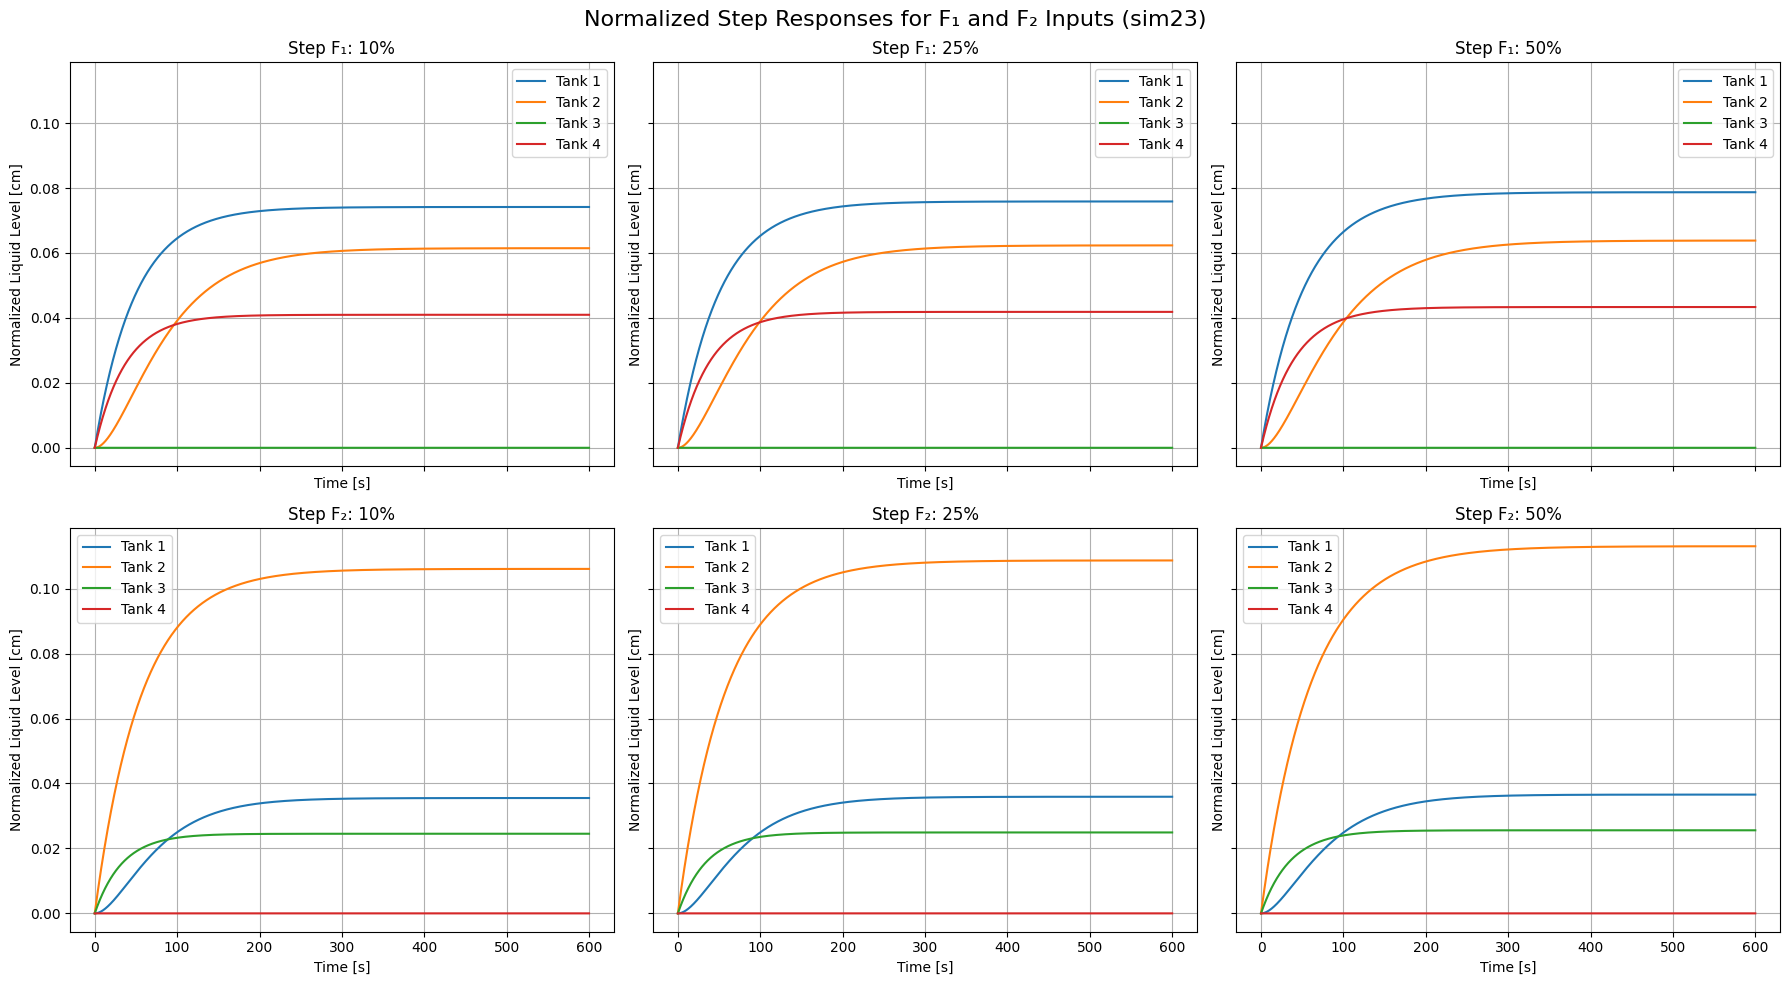

In [ ]:
noise_level = 0
dt = 0.01
step_pers_list = [0.1, 0.25, 0.5]

fig, axs = plt.subplots(2, len(step_pers_list), figsize=(18, 10), sharex=True, sharey=True)

F1_info = []
F2_info = []

for idx, step_pers in enumerate(step_pers_list):
    # --- Common setup ---
    F1_base = np.array([100])
    F2_base = np.array([100])
    F3 = np.array([100])
    F4 = np.array([100])
    A = p[4:8]
    rho = p[11]
    times = np.array([0, 10]) * 60
    tf = times[-1]
    t = np.arange(0, tf + dt, dt)

    # --- Steady-state simulation ---
    u_base = np.array([F1_base, F2_base])
    d = np.array([F3, F4])
    x_ss = fun.sim23(times, dt, x0, u_base, d, p, noise_level=noise_level, plot=False)
    x0_ss = x_ss[:, -1].flatten()

    # ============================
    # Simulation: Step in F1 only
    # ============================
    F1 = F1_base * (1 + step_pers)
    F2 = F2_base
    step_size_F1 = float(F1[0] - F1_base[0])
    u = np.array([F1, F2])
    x = fun.sim23(times, dt, x0_ss, u, d, p, noise_level=noise_level, plot=False)
    xend = x[:, -1].flatten()

    for i in range(4):
        xunit = (x[i, :] - x0_ss[i]) / step_size_F1
        h = xunit / (rho * A[i])

        F1_info.append((t, h))
        axs[0, idx].plot(t, h, label=f'Tank {i+1}')

        # If you want to plot the 10% and 90% of any of the curves to get the rise time
        # if i == 3:
        #     h_ss = h[-1]
        #     # add 10% and 90% lines
        #     axs[0, idx].axhline(0.1 * h_ss, color='gray', linestyle='--', linewidth=0.8)
        #     axs[0, idx].axhline(0.9 * h_ss, color='gray', linestyle='--', linewidth=0.8)

    print()
    axs[0, idx].set_title(f'Step F₁: {int(step_pers * 100)}%')
    axs[0, idx].set_xlabel('Time [s]')
    axs[0, idx].grid(True)

    # ============================
    # Simulation: Step in F2 only
    # ============================
    F1 = F1_base
    F2 = F2_base * (1 + step_pers)
    step_size_F2 = float(F2[0] - F2_base[0])
    u = np.array([F1, F2])
    x = fun.sim23(times, dt, x0_ss, u, d, p, noise_level=noise_level, plot=False)
    xend = x[:, -1].flatten()

    for i in range(4):
        xunit = (x[i, :] - x0_ss[i]) / step_size_F2
        h = xunit / (rho * A[i])
        F2_info.append((t, h))
        axs[1, idx].plot(t, h, label=f'Tank {i+1}')

        # If you want to plot the 10% and 90% of any of the curves to get the rise time
        # if i == 3:    
        #     h_ss = h[-1]
        #     axs[1, idx].axhline(0.1 * h_ss, color='gray', linestyle='--', linewidth=0.8)
        #     axs[1, idx].axhline(0.9 * h_ss, color='gray', linestyle='--', linewidth=0.8)
            
    axs[1, idx].set_title(f'Step F₂: {int(step_pers * 100)}%')
    axs[1, idx].set_xlabel('Time [s]')
    axs[1, idx].grid(True)

# --- Final formatting ---
for row in axs:
    for ax in row:
        ax.set_ylabel('Normalized Liquid Level [cm]')
        ax.legend()

fig.suptitle('Normalized Step Responses for F₁ and F₂ Inputs (sim23)', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# soptd -> second order plus time delay, although it seems like we do not have time delay yet
def soptd_step_response(t, K, T1, T2, tau, beta):

    # G(s)=K (1+beta s) e^{-tau s} / ((1+T1 s)(1+T2 s))
    # Build TF and simulate step with delay

    G = ct.TransferFunction([K*beta, K], [T1*T2, T1+T2, 1]) # NOTE: we cannot include the exponential term (time delay) as it breaks the function

    # delay by shifting time axis; pad with zeros before tau
    y = ct.forced_response(G, T=t[t>=0], U=np.ones_like(t[t>=0]))[1]

    # Here we can add the time delay
    y_delayed = np.interp(t, t+tau, y, left=0.0)
    return y_delayed


# foptd -> first order plus time delay (simpler model for single exponential curves)
def foptd_step_response(t, K, T, tau, beta=0.0):

    # G(s)=K (1+beta s) e^{-tau s} / (1+T s)
    # Build TF and simulate step with delay

    G = ct.TransferFunction([K*beta, K], [T, 1]) 

    # delay by shifting time axis; pad with zeros before tau
    y = ct.forced_response(G, T=t[t>=0], U=np.ones_like(t[t>=0]))[1]
    y_delayed = np.interp(t, t+tau, y, left=0.0)
    return y_delayed

def fit_channel_soptd(t, s, guess, speedup):
        
    if speedup:
        # --- minimal speed-up: downsample to ~0.1 s resolution ---
        t = np.asarray(t, float).ravel()
        s = np.asarray(s, float).ravel()
        dt_est = np.median(np.diff(t))
        target_dt = 0.10  # ≈ 10 Hz fit grid (change to 0.2 for even faster)
        step = max(1, int(round(target_dt / dt_est)))
        t_fit = t[::step]
        s_fit = s[::step]
        # ---------------------------------------------------------
    
    else:
        t_fit = t
        s_fit = s

    # guess = (K, T1, T2, tau, beta)
    bounds_lower = [0.0,  1e-3, 1e-3, 0.0,  -10.0]
    bounds_upper = [np.inf, 200.0, 200.0, 100.0, 10.0]
    popt, _ = curve_fit(
        soptd_step_response, t_fit, s_fit, p0=guess,
        bounds=(bounds_lower, bounds_upper), maxfev=20000
    )
    K, T1, T2, tau, beta = popt

    G = ct.TransferFunction([K*beta, K], [T1*T2, T1+T2, 1])
    return G, {'K': K, 'T1': T1, 'T2': T2, 'tau': tau, 'beta': beta}


def fit_channel_foptd(t, s, guess, speedup=False):

    if speedup:
        # --- minimal speed-up: downsample to ~0.1 s resolution ---
        t = np.asarray(t, float).ravel()
        s = np.asarray(s, float).ravel()
        dt_est = np.median(np.diff(t))
        target_dt = 0.10  # ≈ 10 Hz fit grid (change to 0.2 for even faster)
        step = max(1, int(round(target_dt / dt_est)))
        t_fit = t[::step]
        s_fit = s[::step]
        # ---------------------------------------------------------
    else:
        t_fit = t
        s_fit = s

    # guess = (K, T, tau, beta)
    bounds_lower = [0.0,  1e-3, 0.0,  -10.0]
    bounds_upper = [np.inf, 200.0, 100.0, 10.0]
    popt, _ = curve_fit(
        foptd_step_response, t_fit, s_fit, p0=guess,
        bounds=(bounds_lower, bounds_upper), maxfev=8000
    )
    K, T, tau, beta = popt

    G = ct.TransferFunction([K*beta, K], [T, 1])
    return G, {'K': K, 'T': T, 'tau': tau, 'beta': beta}


# choose which step block to use: "10%", "25%", or "50%"
SELECT_BLOCK = "50%"   # change to "50%" if we want 50%

_BLOCK_IDX = {"10%": 0, "25%": 1, "50%": 2}[SELECT_BLOCK]
def pick(F_info, tank_number_1to4):
    # F_info is [tanks 1..4] repeated per step size; block size = 4, cuz 4 tanks
    return F_info[_BLOCK_IDX*4 + (tank_number_1to4-1)]


# -------------------- SOME NOTES FOR THE PARAMETER GUESSES ---------------------
# From the graphs, we guess the initial parameters, the rest is done by the curvefit() algorithm

# For a first-order step response:
# Tr (rise-time) = t90 - t10 = T * (ln(0.9) - ln(0.1)) = T * ln(9) ≈ T * 2.2
# => T ≈ Tr / 2.2

# For a second-order (two real poles) step response:
# Tr ≈ time from 10% to 90% of steady state
# A good initial guess is:
# T1 ≈ 0.3 * Tr
# T2 ≈ 1.0 * Tr

# None of the graphs seems to show a time delay or a pole so we set tau and beta to 0

# Use a small T2 for the first order transfer functions (e.g. 1e-3) instead of 0
# → avoids singularities in denominator and keeps the fit numerically stable
# -------------------------------------------------------------------------------


# All of the parameters here are manlually put in by reading of the step responses

channels = [        # guess (K, T1, T2, tau, beta) for 2nd order or (K, T, tau, beta) for 1st order
    ('F1 -> T1', pick(F1_info, 1),   (0.07625, 105/2.2, 0.0, 0.0)),             # 1st-order
    ('F1 -> T2', pick(F1_info, 2),   (0.06255, 160*0.3, 160*1.0, 0.0, 0.0)),    # 2nd-order
    ('F1 -> T3', None,          0),                                             # no connection
    ('F1 -> T4', pick(F1_info, 4),   (0.04206,  89/2.2, 0.0, 0.0)),             # 1st-order
    ('F2 -> T1', pick(F2_info, 1),   (0.03600593, 130*0.3, 130*1.0, 0.0, 0.0)), # 2nd-order
    ('F2 -> T2', pick(F2_info, 2),   (0.10928063, 135/2.2, 0.0, 0.0)),          # 1st-order
    ('F2 -> T3', pick(F2_info, 3),   (0.02501051,  79/2.2, 0.0, 0.0)),          # 1st-order
    ('F2 -> T4', None,          0),                                             # no connection
]

# We store all the transfer functions in a list
SISO_tf = []
fit_params = []  # keep params to inspect/report them
labels = []

speedup = True # Cell takes around 45 seconds to run when speedup = False

for label, curve, guess in channels:
    if (guess == 0) or (curve is None):
        SISO_tf.append(0)
        fit_params.append(None)
        continue
    t_i, s_i = curve  # (time, normalized response)
    g = np.atleast_1d(guess)
    if g.size == 4:   # first order
        tf_i, params_i = fit_channel_foptd(t=t_i, s=s_i, guess=guess, speedup=speedup)
    elif g.size == 5: # second order
        tf_i, params_i = fit_channel_soptd(t=t_i, s=s_i, guess=guess, speedup=speedup)
    else:
        raise ValueError("Only 4 or 5 parameters are allowed")
    SISO_tf.append(tf_i)
    labels.append(label)
    fit_params.append(params_i)


In [ ]:
# ------- We validate the transfer functions --------
fig, axs = plt.subplots(len(channels), 1, figsize=(9, 3*len(channels)), sharex=False)

if len(channels) == 1:
    axs = [axs]

for ax, (label, curve, guess), G in zip(axs, channels, SISO_tf):
    if G == 0 or curve is None:
        ax.text(0.5, 0.5, f"{label}: No connection (G=0)", ha='center', va='center')
        ax.set_axis_off()
        continue

    t, s_meas = curve
    y_model = ct.forced_response(G, T=t, U=np.ones_like(t))[1]
    rmse = np.sqrt(np.mean((y_model - s_meas)**2))

    ax.plot(t, s_meas, 'k', lw=2, label='Measured')
    ax.plot(t, y_model, 'r--', label='Model')
    ax.grid(True)
    ax.set_title(f"{label}   RMSE={rmse:.4f}")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Norm. level")

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.suptitle("Validation of Identified SISO Transfer Functions", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## Transfer functions derived from Step responses:

**F₁ → T₁ (1. order)**

$$
G_{1}(s) = \frac{0.01090s + 0.07416}{48.9957s + 1}
$$

**F₁ → T₂ (2. order)**

$$
G_{2}(s) = \frac{0.09879s + 0.06148}{2070.53s^{2} + 93.2449s + 1}
$$

**F₁ → T₃**

$$
G_{3}(s) = 0
$$

**F₁ → T₄ (1. order)**

$$
G_{4}(s) = \frac{0.005109s + 0.04096}{37.3638s + 1}
$$

**F₂ → T₁ (2. order)**

$$
G_{5}(s) = \frac{0.04384s + 0.03552}{1610.74s^{2} + 81.8881s + 1}
$$

**F₂ → T₂ (1. order)**

$$
G_{6}(s) = \frac{0.02308s + 0.10608}{56.4709s + 1}
$$

**F₂ → T₃ (1. order)**

$$
G_{7}(s) = \frac{0.002490s + 0.02452}{33.4847s + 1}
$$

**F₂ → T₄**

$$
G_{8}(s) = 0
$$


# Problem 7
QP solver interface
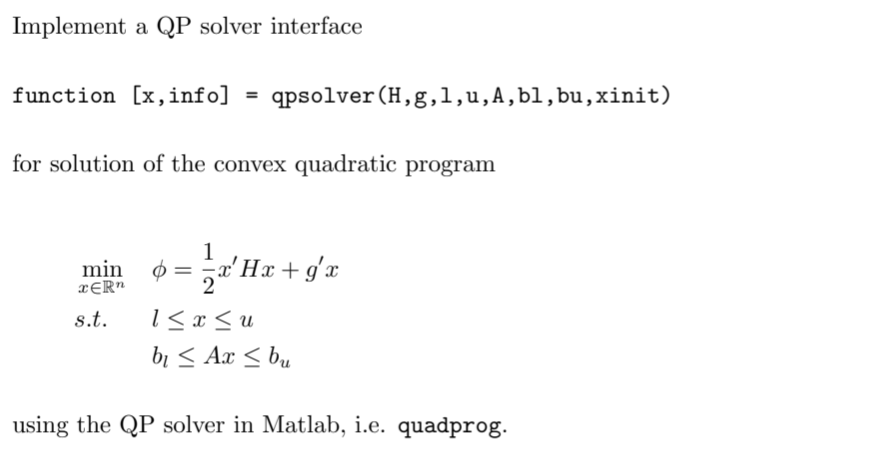

see function qpsolver in the functions document

In [ ]:
def qpsolver(H, g, l, u, A, bl, bu, xinit=None):
    n = H.shape[0]
    x = cp.Variable(n)

    # Objective function
    objective = cp.Minimize(0.5 * cp.quad_form(x, H) + g.T @ x)

    # Constraints
    constraints = []
    if l is not None:
        constraints.append(x >= l)
    if u is not None:
        constraints.append(x <= u)
    if A is not None:
        if bl is not None:
            constraints.append(A @ x >= bl)
        if bu is not None:
            constraints.append(A @ x <= bu)

    # Solve the problem
    prob = cp.Problem(objective, constraints)
    min_val = prob.solve()

    return x.value, min_val